In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import nltk
import matplotlib

### Data

In [4]:
data = pd.read_csv("npr.csv")
data.shape

(11992, 1)

### Preprocess

In [8]:
import string 
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet

SW = set(stopwords.words('english'))


In [12]:
%%time
def preprocess(text):
    text = text.lower()
    text = text.translate( str.maketrans(' ', ' ', string.punctuation))
    text = [word for word in word_tokenize(text)]
    text = [word for word in text if not any(c.isdigit() for c in word) ]
    text = [t for t in text if len(t) > 0]
    text = [t for t in text if len(t) > 1]
    return text

data.Article = data.Article.apply(preprocess)

### Bigrams, Trigrams, Lemmatization

In [20]:
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from nltk.stem import WordNetLemmatizer

articles = data.Article.to_list()

bigram = gensim.models.Phrases(articles,
                            num_topics=in_count = 5,
                              threshold = 100)

trigram = gensim.models.Phrases( bigram[articles],
                                threshold = 100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def process_text(texts):
    texts = [ [word for word in simple_preprocess(str(doc)) if word not in SW ]
                for doc in texts]
    texts = [ trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    
    def get_wordnet_pos(word):
        tag = nltk.pos_tag(word)[0][1][0].upper()
        tag_dict = { "J" : wordnet.ADJ,
                   "N" : wordnet.NOUN,
                   "V" : wordnet.VERB,
                   "R" : wordnet.ADV}
        return tag_dict.get( tag, wordnet.NOUN)
    
    lemmatizer = WordNetLemmatizer()
    for sentence in texts:
        texts_out.append( [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in sentence])
    texts_out = [[word for word in simple_preprocess(str(doc)) if word
                             not in SW] for doc in texts_out]
    
    return texts_out


data_ready = process_text(articles)

## TOPIC MODEL

In [23]:
id2word = corpora.Dictionary(data_ready)

corpus = [id2word.doc2bow(text) for text in data_ready]

#LDA MODEL
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = id2word,
                                           num_topics = 8,
                                           random_state = 100,
                                           update_every = 1,
                                           chunksize = 10,
                                           passes = 10,
                                           alpha = 'symmetric',
                                           iterations = 100,
                                           per_word_topics = True)


### Dominant topic and its percentage contribution in each document¶

In [24]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data.Article.to_list()):
    # Init output
    sent_topics_df = pd.DataFrame()

    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model,
                                                  corpus=corpus,
                                                  texts=data_ready)


df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.6021,"trump, president, election, say, republican, c...","[washington, even, policy, bipartisan, politic..."
1,1,3.0,0.4870,"trump, president, election, say, republican, c...","[donald, trump, used, twitter, preferred, mean..."
2,2,3.0,0.6428,"trump, president, election, say, republican, c...","[donald, trump, unabashedly, praising, putin, ..."
3,3,3.0,0.6331,"trump, president, election, say, republican, c...","[updated_et, putin, say, russia, expelling, di..."
4,4,7.0,0.2286,"year, one, say, world, new, time, good, two, a...","[photography, illustration, video, data, visua..."
5,5,4.0,0.5136,"say, like, people, one, make, think, know, tim...","[want, join, yoga, class, hat, beatific, instr..."
6,6,1.0,0.5411,"say, study, health, people, children, universi...","[publicly, supported, debunked, claim, vaccine..."
7,7,4.0,0.6089,"say, like, people, one, make, think, know, tim...","[standing, airport, exit, debating, whether, g..."
8,8,4.0,0.5540,"say, like, people, one, make, think, know, tim...","[movie, trying, realistic, perhaps, way, summo..."
9,9,4.0,0.4151,"say, like, people, one, make, think, know, tim...","[eighteen, years_ago, new, year, eve, david, f..."


### The most representative sentence for each topic¶


In [25]:
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)


,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.4163,"food, brexit, eat, china, animal, chinese, farm, japanese, peanut, germany","[turkeyphobic, bored, bird, fear, got, main, dish, idea, think, cool, put, center, roast, table,..."
1,1.0,0.7360,"say, study, health, people, children, university, case, research, found, percent","[make, great, progress, treating, people, infected, hiv, get, cancer, le, likely, get, care, nee..."
2,2.0,0.7155,"say, police, attack, city, report, people, reported, military, war, told","[islamic_state, monday, say, responsible, attack, new, year, eve, celebration, nightclub, istanb..."
3,3.0,0.7885,"trump, president, election, say, republican, campaign, obama, state, party, democrat","[may, first, foreign, leader, president, trump, hosted, white_house, joined, trump, joint, white..."
4,4.0,0.8568,"say, like, people, one, make, think, know, time, thing, want","[editor_note, story, contains, quote, racial_slur, used, calvin, burn, trouble, getting, daughte..."
5,5.0,0.8570,"say, year, state, would, people, company, country, law, government, million","[house, republican, pass, bill, replace, signed, law, american, health_care_act, affect, access,..."
6,6.0,0.5230,"student, music, school, song, artist, schools, album, education, voice, teacher","[robert_glasper, always, making, music, solo, quartet, robert_glasper, experiment, released, alb..."
7,7.0,0.8175,"year, one, say, world, new, time, good, two, around, first","[wait, final, finally, well, least, game, one, follow, along, npr, reporter, fan, tonight, game,..."


### Frequency Distribution of Word Counts in Documents¶


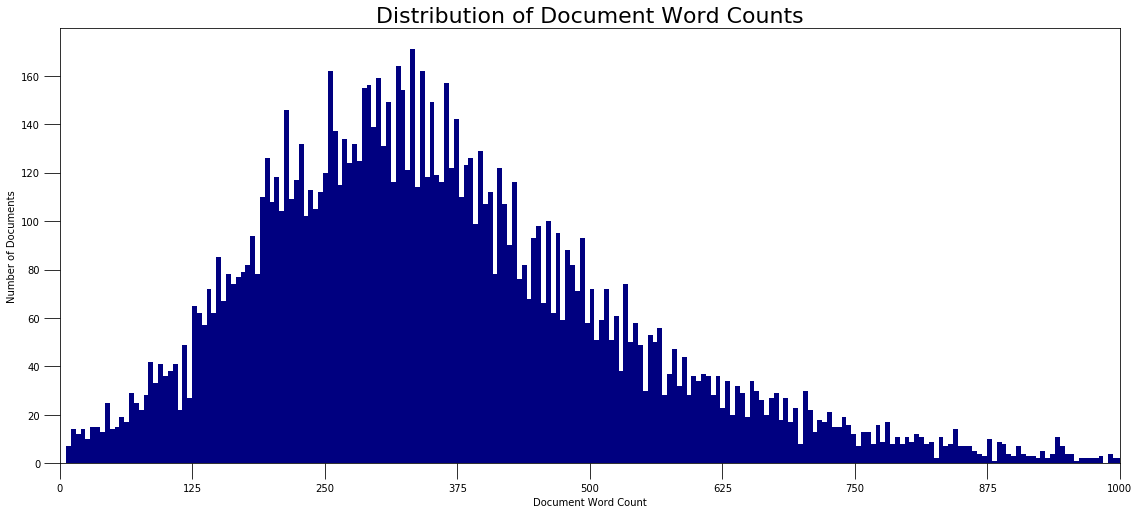

In [26]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(19,8))
plt.hist(doc_lens, bins = 1000, color='navy')

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

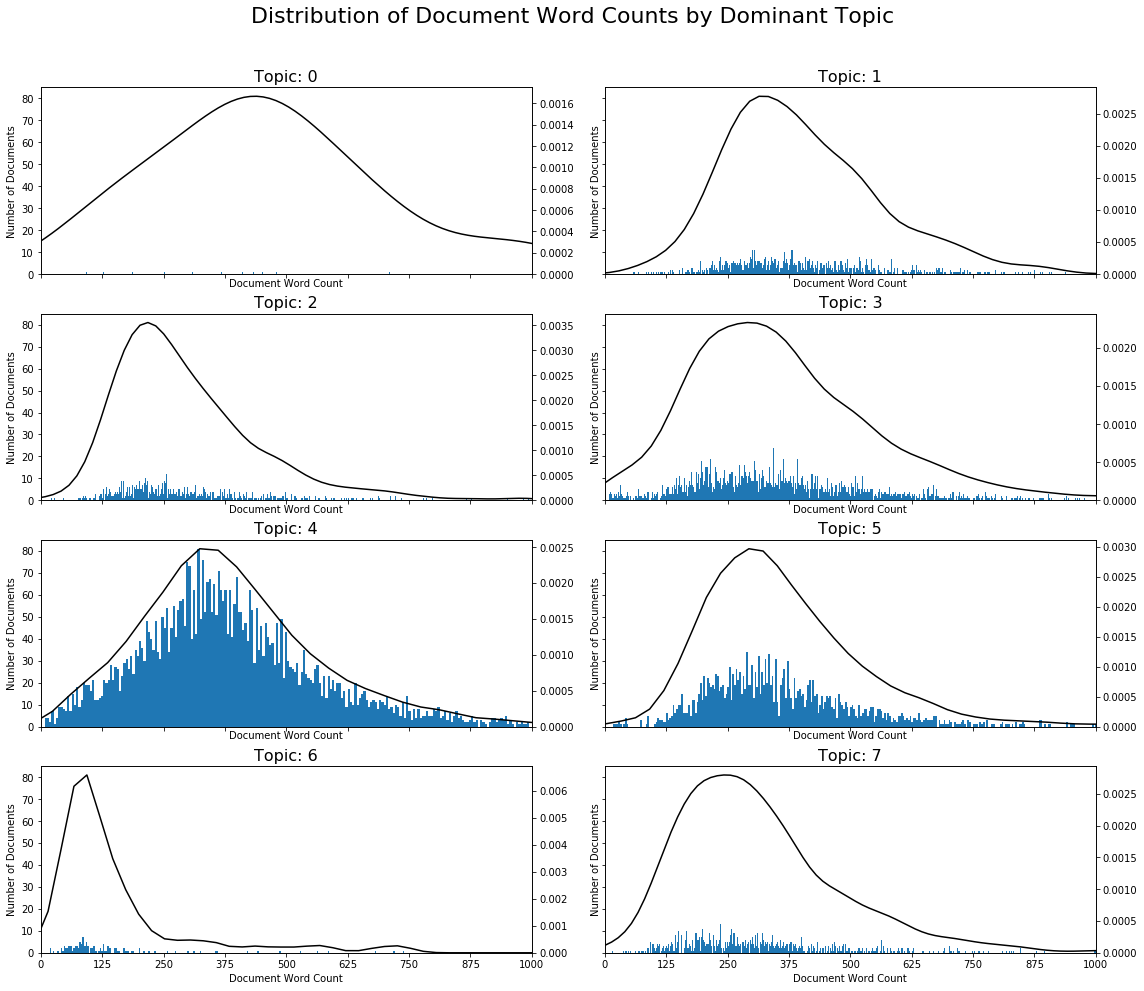

In [27]:
import seaborn as sns

fig, axes = plt.subplots(4, 2, figsize=(16,14), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000)
    ax.tick_params(axis='y')
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents')
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

### Word Clouds of Top N Keywords in Each Topic¶


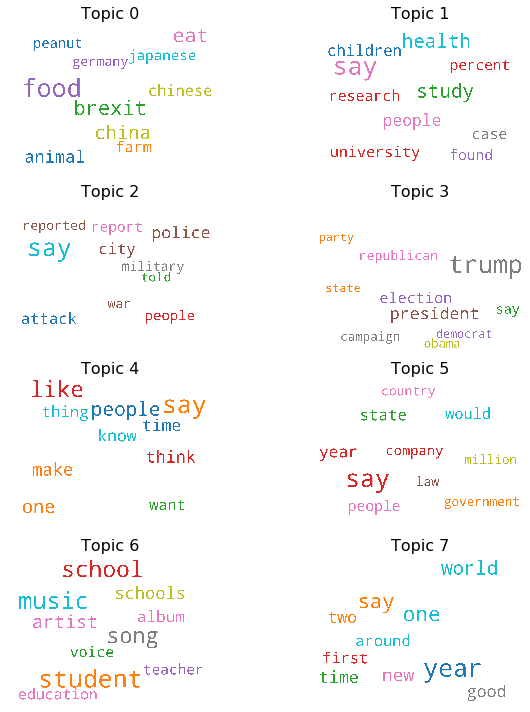

In [32]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS

cloud = WordCloud(stopwords=SW,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(4, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### t-SNE Clustering Chart¶


In [33]:
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca');
tsne_lda = tsne_model.fit_transform(arr);



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8562 samples in 0.023s...
[t-SNE] Computed neighbors for 8562 samples in 0.662s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8562
[t-SNE] Computed conditional probabilities for sample 2000 / 8562
[t-SNE] Computed conditional probabilities for sample 3000 / 8562
[t-SNE] Computed conditional probabilities for sample 4000 / 8562
[t-SNE] Computed conditional probabilities for sample 5000 / 8562
[t-SNE] Computed conditional probabilities for sample 6000 / 8562
[t-SNE] Computed conditional probabilities for sample 7000 / 8562
[t-SNE] Computed conditional probabilities for sample 8000 / 8562
[t-SNE] Computed conditional probabilities for sample 8562 / 8562
[t-SNE] Mean sigma: 0.051458
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.901093
[t-SNE] KL divergence after 1000 iterations: 1.400337


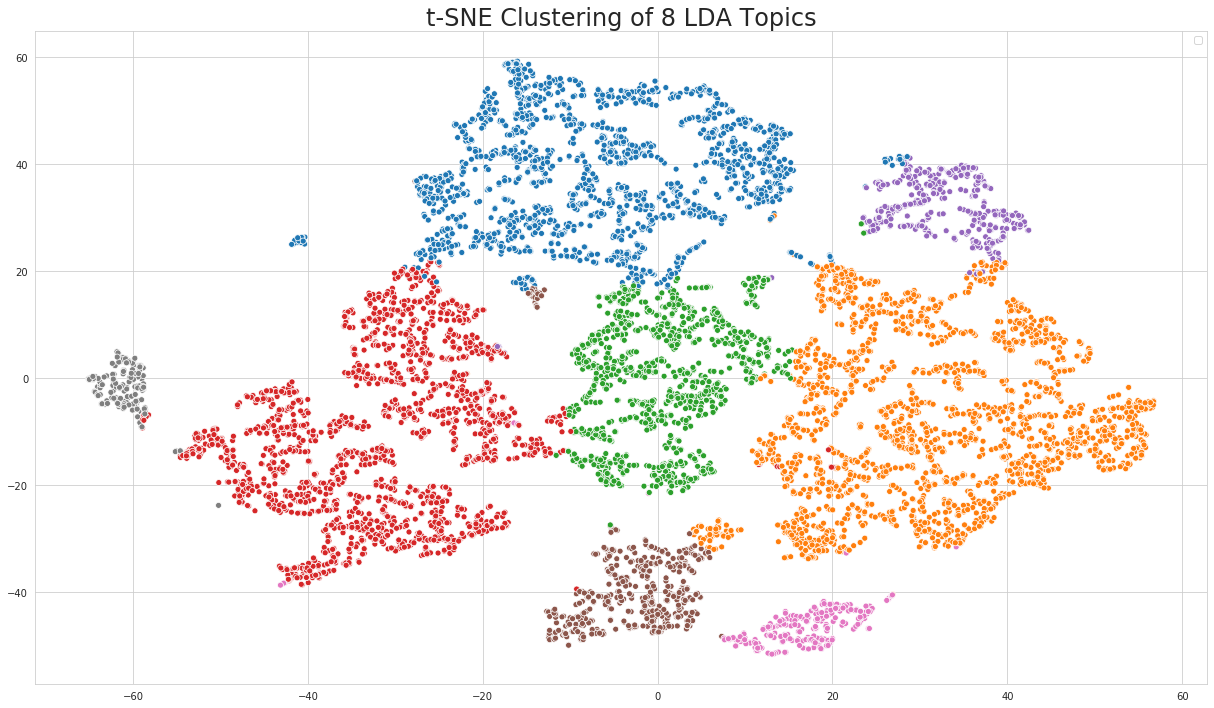

In [36]:
plt.figure(figsize= (21, 12))
plt.title("t-SNE Clustering of 8 LDA Topics", fontsize= 24)
sns.set_style('whitegrid')
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
sns.scatterplot(x=tsne_lda[:,0], y=tsne_lda[:,1], hue=mycolors[topic_num])
plt.legend("")
plt.show()